## Part 1

### 1.1

In [49]:
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn import metrics
from math import sqrt
import re
import emoji
import sklearn.preprocessing
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

In [50]:
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt

hashtagData = dict()


pst_tz = pytz.timezone('US/Pacific')
oneHr = datetime.timedelta(minutes=60)
nflNumTweets = None
superbowlNumTweets = None

in_dir = 'tweet_data'

for root, dirs, files in os.walk(in_dir):
    path = root.split(os.sep)
    dateObj = None
    for f in files:
        #avg no. of tweets per hr
        #avg no. of followers of users posting the tweets
        fullPath = "/".join(path) + "/" + f
        hashtag = f[8: -4]
        print("\n\n", hashtag)
        
        numTweetsPerHr = OrderedDict()
        numFollowers = dict()
        numRetweets = dict()
        
        fh = open(fullPath, 'r', encoding='utf8')
            
        dfRowObjs = []
        for line in fh.readlines():
            jsonObject = json.loads(line)
            
            ts = jsonObject['citation_date']
            userID = jsonObject['tweet']['user']['id']
            tweetID = jsonObject['tweet']['id']
            followers = jsonObject['author']['followers']
            retweets = jsonObject['metrics']['citations']['total']
            dateObj = datetime.datetime.fromtimestamp(ts, pst_tz)
            
            dfRowObj = {"date": dateObj, "tweetID": tweetID, "userID": userID, "followers": followers, "retweets": retweets, "timeOfDay": dateObj.hour}
            
            dfRowObjs.append(dfRowObj)

        df = pd.DataFrame(dfRowObjs)
        
        hashtagData[hashtag] = df



 gohawks


 gopatriots


 nfl


 patriots


 sb49


 superbowl



Hashtag:  gohawks
Average Number of Tweets per Hour:  324.9326424870466
Average Number of Followers per User:  2203.931767444827
Average Number of Retweets per Tweet:  2.014617085512608

Hashtag:  gopatriots
Average Number of Tweets per Hour:  45.62086956521739
Average Number of Followers per User:  1401.8955093016164
Average Number of Retweets per Tweet:  1.4000838670326319

Hashtag:  nfl


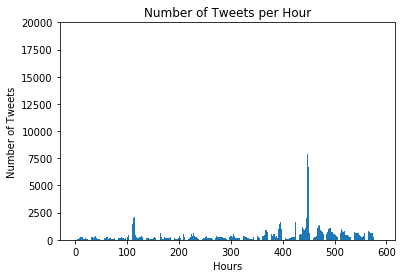

Average Number of Tweets per Hour:  441.26746166950596
Average Number of Followers per User:  4653.252285502502
Average Number of Retweets per Tweet:  1.5385331089011056

Hashtag:  patriots
Average Number of Tweets per Hour:  834.2640545144804
Average Number of Followers per User:  3309.978828415827
Average Number of Retweets per Tweet:  1.7828156491659402

Hashtag:  sb49
Average Number of Tweets per Hour:  1418.4408233276158
Average Number of Followers per User:  10267.31684948685
Average Number of Retweets per Tweet:  2.5111487863247035

Hashtag:  superbowl


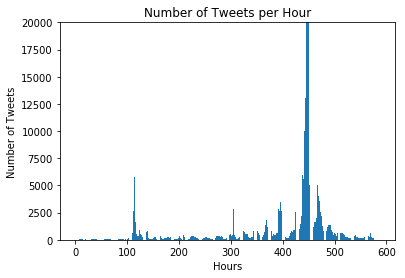

Average Number of Tweets per Hour:  2297.7291311754684
Average Number of Followers per User:  8858.974662784603
Average Number of Retweets per Tweet:  2.3882723999030224


In [51]:
for hashtag in hashtagData:
    print("\nHashtag: ", hashtag)
    df = hashtagData[hashtag]
    x = df.groupby(pd.Grouper(key='date', freq='h')).count()
    
    if hashtag == 'superbowl' or hashtag == 'nfl':
        plt.bar(range(len(x.iloc[:,1])), x.iloc[:,1])
        plt.xlabel("Hours")
        plt.ylabel("Number of Tweets")
        plt.title("Number of Tweets per Hour")
        plt.ylim(ymax=20000)
        plt.show()
        
    avgNumTweetsPerHr  = sum(x.iloc[:,1]) / len(x.iloc[:,1])
    print("Average Number of Tweets per Hour: ",avgNumTweetsPerHr)
    avgFollowers = sum(df.iloc[:, 1]) / len(df.iloc[:, 1])
    avgRetweets = sum(df.iloc[:, 2]) / len(df.iloc[:,2])
    print("Average Number of Followers per User: ", avgFollowers)
    print("Average Number of Retweets per Tweet: ", avgRetweets)

### 1.2

In [77]:

for hashtag in hashtagData:
    
    print("\nHashtag: ", hashtag)
    df = hashtagData[hashtag]
    x = df.groupby(pd.Grouper(key='date', freq='h'))
    
    labels = list()
    features = list()
    
    gb = x.groups
    prevRows = 0
    for key in gb.keys():
        newRows = gb[key]
        if newRows - prevRows == 0:
            #this hr has no tweets
            numTweets = 0
            numRetweets = 0
            numFollowers = 0
            maxFollowers = 0
            hrDay = key.hour
        else:
            var = x.get_group(key)
            numTweets = len(var)
            numRetweets = sum(var['retweets'])
            numFollowers = sum(var['followers'])
            maxFollowers = max(var['followers'])
            hrDay = var['timeOfDay'].iloc[0]
            
        l = [numTweets, numRetweets, numFollowers, maxFollowers, hrDay]
        features.append(l)
        prevRows = newRows
    
    for row in features[1:]:
        labels.append(row[0])
    del features[-1]
    
    X = np.array(features)
    X = sm.add_constant(X, prepend=True)
    y = np.array(labels)
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    print("P-Values:",results.pvalues)
    predictions = results.predict()
    rmse = sqrt(metrics.mean_squared_error(y, predictions))
    print("RMSE: ", rmse)
    


Hashtag:  gohawks
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     102.6
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           3.70e-77
Time:                        17:48:15   Log-Likelihood:                -4796.7
No. Observations:                 578   AIC:                             9605.
Df Residuals:                     572   BIC:                             9632.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.7373     78.781 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     475.2
Date:                Sun, 18 Mar 2018   Prob (F-statistic):          1.09e-201
Time:                        17:48:18   Log-Likelihood:                -5717.7
No. Observations:                 582   AIC:                         1.145e+04
Df Residuals:                     576   BIC:                         1.147e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.0606    365.278      0.624      0.5

### 1.3

In [53]:
def countEmoji(text):
    textList = list(text)
    count = 0
    for char in textList:
        if char in emoji.UNICODE_EMOJI:
            count += 1
    return count

In [54]:
def countSpecialCharacters(text):
    newString = re.sub('[\w]+', '', text)
    textList = list(newString)
    count = len(newString) - textList.count(' ')
    return count

In [55]:
def countUpperCase(text):
    if len(text) > 0:
        s = sum(1 for c in text if c.isupper()) / len(text)
    else:
        s = 0
        
    return s

In [56]:
def fh_to_df(fh):
    dfRowObjs = []

    for line in fh.readlines():
        jsonObject = json.loads(line)

        ts = jsonObject['citation_date']
        userID = jsonObject['tweet']['user']['id']
        tweetID = jsonObject['tweet']['id']
        followers = jsonObject['author']['followers']
        retweets = jsonObject['metrics']['citations']['total']
        numURLs = len(jsonObject['tweet']['entities']['urls'])
        numHashtags = len(jsonObject['tweet']['entities']['hashtags'])
        dateObj = datetime.datetime.fromtimestamp(ts, pst_tz)
        statusCount = jsonObject['tweet']['user']['statuses_count']
        friendCount = jsonObject['tweet']['user']['friends_count']
        favouritesCount = jsonObject['tweet']['user']['favourites_count']
        impressions = jsonObject['metrics']['impressions']
        userVerified = jsonObject['tweet']['user']['verified']
        tweetText = jsonObject['tweet']['text']
        language = jsonObject['tweet']['lang']
        rankingScore = jsonObject['metrics']['ranking_score']
        momentum = jsonObject['metrics']['momentum']
        
        fps = jsonObject['firstpost_date']
        firstPostDate = datetime.datetime.fromtimestamp(fps, pst_tz)

        dfRowObj = {"date": dateObj, "tweetID": tweetID, "userID": userID, \
                    "followers": followers, "retweets": retweets, "timeOfDay": dateObj.hour, \
                    "numOfURLs": numURLs, "numOfHashtags": numHashtags,\
                    "statusCount": statusCount, "friendCount": friendCount, "favouritesCount":favouritesCount,\
                    "Impressions": impressions, "userVerified":userVerified,\
                    "tweetText": tweetText, "language": language, "rankingScore": rankingScore, \
                    "momentum": momentum, "firstpost_date": firstPostDate}

        dfRowObjs.append(dfRowObj)

    df = pd.DataFrame(dfRowObjs)
    
    return df

In [57]:
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt

hashtagData = dict()


pst_tz = pytz.timezone('US/Pacific')
oneHr = datetime.timedelta(minutes=60)
nflNumTweets = None
superbowlNumTweets = None

in_dir = 'tweet_data'

for root, dirs, files in os.walk(in_dir):
    path = root.split(os.sep)
    dateObj = None
    for f in files:
        fullPath = "/".join(path) + "/" + f
        hashtag = f[8: -4]
        print("\n\n", hashtag)
        print(fullPath)
        
        numTweetsPerHr = OrderedDict()
        numFollowers = dict()
        numRetweets = dict()
        
        fh = open(fullPath, 'r', encoding='utf8')
            
        df = fh_to_df(fh)
        
        hashtagData[hashtag] = df



 gohawks
tweet_data/tweets_#gohawks.txt


 gopatriots
tweet_data/tweets_#gopatriots.txt


 nfl
tweet_data/tweets_#nfl.txt


 patriots
tweet_data/tweets_#patriots.txt


 sb49
tweet_data/tweets_#sb49.txt


 superbowl
tweet_data/tweets_#superbowl.txt


In [82]:
def computeFeatures(df, groupByFirstPostDate=False, perHour=True):
    
    features = list()

    if perHour:
        if groupByFirstPostDate:
            x = df.groupby(pd.Grouper(key='firstpost_date', freq='h'))
        else:
            x = df.groupby(pd.Grouper(key='date', freq='h'))
    else:
        x = df.groupby(pd.Grouper(key='date', freq='min'))
        
    gb = x.groups
    prevRows = 0
    index1 = 0
    index2 = 0
        
    for key in gb.keys():
        
        if str(key) == '2015-02-01 08:00:00-08:00':
            index1 = len(features) - 1
        if str(key) == '2015-02-01 20:00:00-08:00':
            index2 = len(features) - 1
        
        newRows = gb[key]
        if newRows - prevRows == 0:
            #this hr has no tweets
            numTweets = 0
            numRetweets = 0
            numFollowers = 0
            maxFollowers = 0
            avgURLs = 0
            avgHashtags = 0
            statusCount = 0
            friendCount = 0
            favouriteCount = 0
            impressions = 0
            numUsers = 0
            uniqueLanguages = 0
            uniqueUserVerified = 0
            emoticonCount = 0
            avgUpperCase = 0
            specialCharacterCount = 0
            avgLenTweet = 0
            hrDay = key.hour
            avgRankingScore = 0
            avgMomentum = 0
        else:
            var = x.get_group(key)
            
            numTweets = len(var)
            
            numRetweets = sum(var['retweets'])
            
            numFollowers = sum(var['followers'])
            
            maxFollowers = max(var['followers'])
            
            avgURLs = sum(var['numOfURLs'])
            
            avgHashtags = sum(var['numOfHashtags'])
            
            statusCount = sum(var['statusCount'])
            
            friendCount = sum(var['friendCount'])
            
            favouriteCount = sum(var['favouritesCount'])
            
            impressions = sum(var['Impressions'])

            hrDay = var['timeOfDay'].iloc[0]
            
            numUsers = len(set(var['userID']))
            
            uniqueLanguages = len(set(var['language']))
            
            
            verifiedUserIndices = np.where(var['userVerified'])[0]
            verifiedUsers = list()
            userIDs = var['userID'].tolist()
            for index in verifiedUserIndices:
                verifiedUsers.append(userIDs[index])
            
            uniqueUserVerified = len(set(verifiedUsers))
            
            avgRankingScore = sum(var['rankingScore'])
            
            avgMomentum = sum(var['momentum'])
                        
            avgLenTweet = 0
            emoticonCount = 0
            avgUpperCase = 0
            specialCharacterCount = 0
            
            tweets = var['tweetText']
            
            for tweet in tweets:
                emoticonCount += countEmoji(tweet)
                avgUpperCase += countUpperCase(tweet)
                specialCharacterCount += countSpecialCharacters(tweet)
                avgLenTweet += len(tweet)
                
            avgUpperCase = avgUpperCase
            avgLenTweet = avgLenTweet
            
            
            
        l = [numTweets,numRetweets, numFollowers, maxFollowers,\
            avgURLs, avgHashtags, statusCount, friendCount,\
            favouriteCount, impressions, numUsers, uniqueLanguages,\
            uniqueUserVerified, emoticonCount, avgUpperCase, hrDay, \
            specialCharacterCount, avgLenTweet, avgRankingScore, avgMomentum]
        
        features.append(l)
        prevRows = newRows
            
    return features, index1, index2
    


Hashtag:  gohawks
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     85.72
Date:                Sun, 18 Mar 2018   Prob (F-statistic):          2.57e-155
Time:                        18:21:54   Log-Likelihood:                -4575.5
No. Observations:                 578   AIC:                             9193.
Df Residuals:                     557   BIC:                             9285.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -103.7736     72.196 

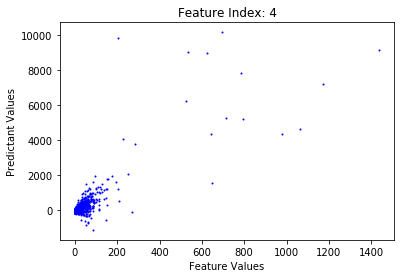

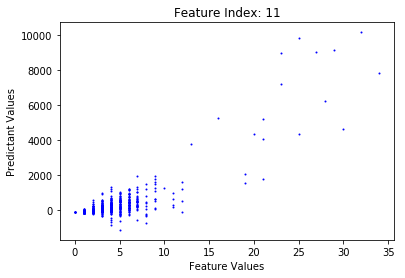

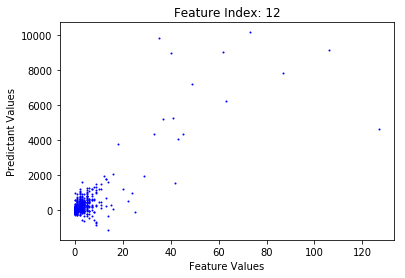

Feature Selection Using p-values


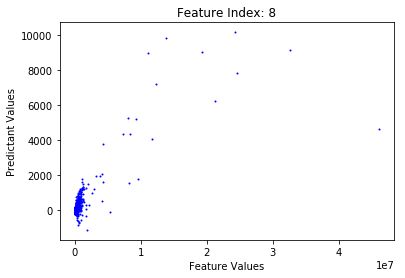

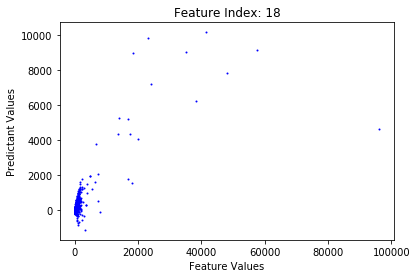

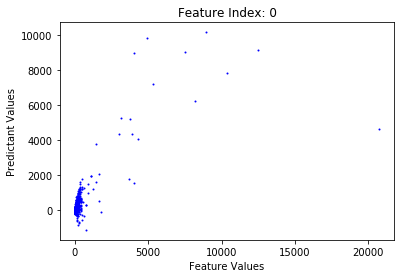


Hashtag:  gopatriots
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     852.8
Date:                Sun, 18 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:21:56   Log-Likelihood:                -3104.6
No. Observations:                 574   AIC:                             6251.
Df Residuals:                     553   BIC:                             6343.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1371      5.1

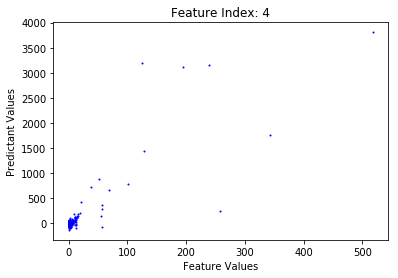

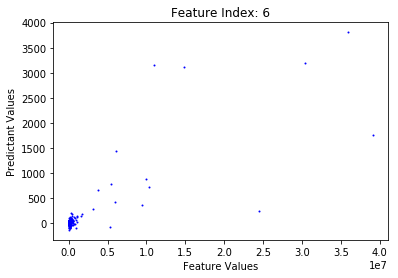

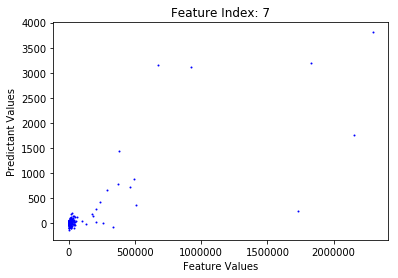

Feature Selection Using p-values


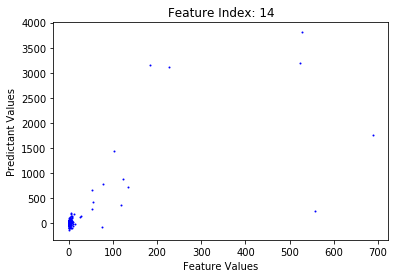

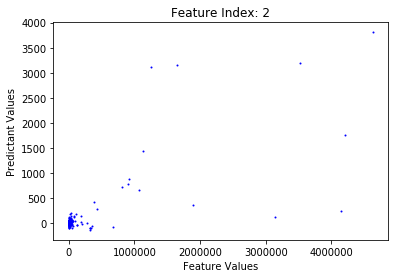

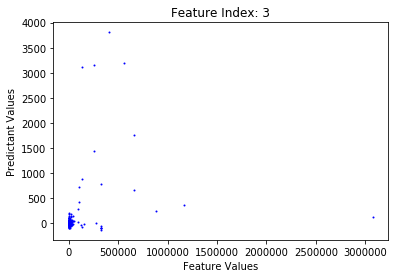


Hashtag:  nfl
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     94.44
Date:                Sun, 18 Mar 2018   Prob (F-statistic):          2.38e-165
Time:                        18:22:05   Log-Likelihood:                -4374.8
No. Observations:                 586   AIC:                             8792.
Df Residuals:                     565   BIC:                             8883.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.1547     52.546     

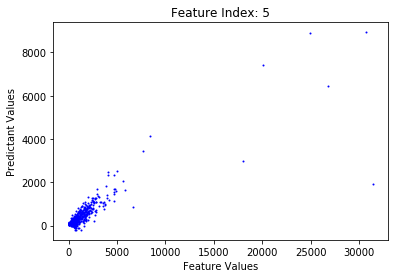

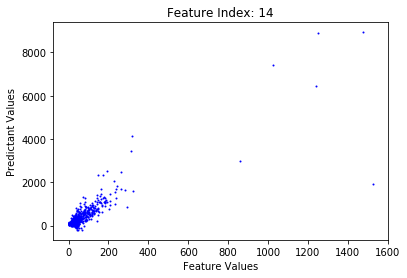

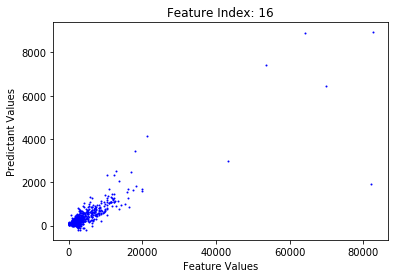

Feature Selection Using p-values


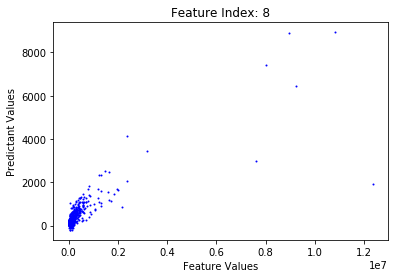

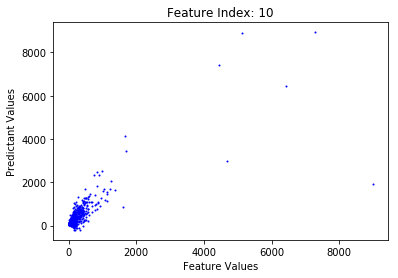

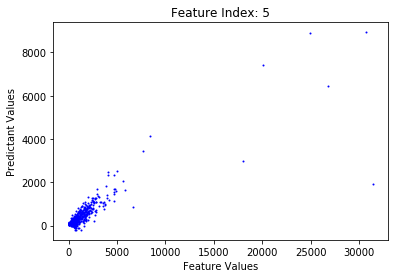


Hashtag:  patriots
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     140.2
Date:                Sun, 18 Mar 2018   Prob (F-statistic):          5.80e-204
Time:                        18:22:17   Log-Likelihood:                -5223.8
No. Observations:                 586   AIC:                         1.049e+04
Df Residuals:                     565   BIC:                         1.058e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2717    204.664

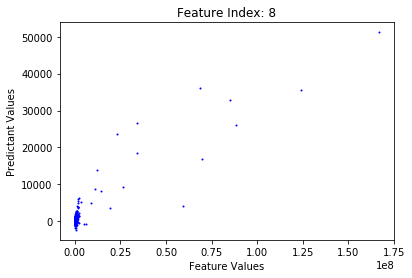

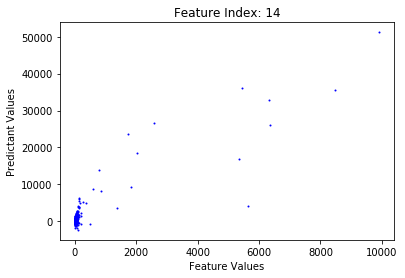

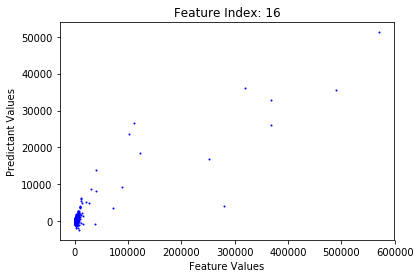

Feature Selection Using p-values


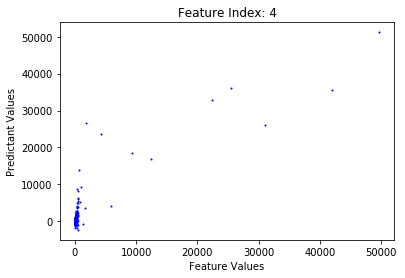

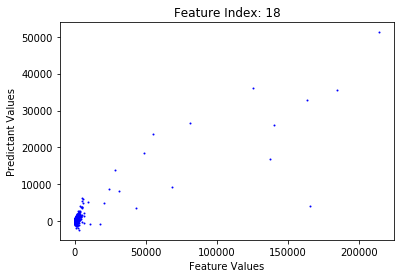

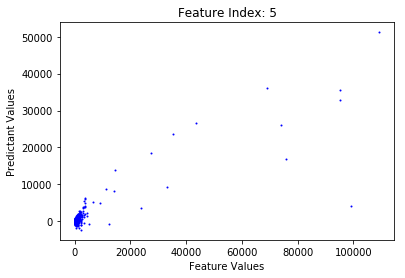


Hashtag:  sb49
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     371.7
Date:                Sun, 18 Mar 2018   Prob (F-statistic):          4.09e-308
Time:                        18:22:37   Log-Likelihood:                -5420.1
No. Observations:                 582   AIC:                         1.088e+04
Df Residuals:                     561   BIC:                         1.097e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.6752    264.684    

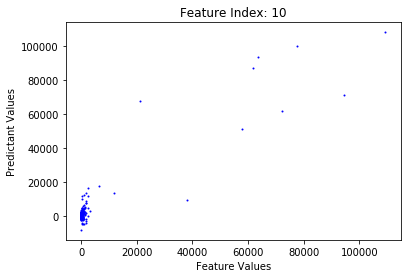

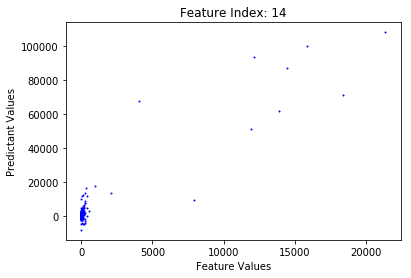

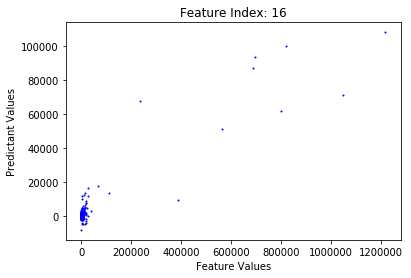

Feature Selection Using p-values


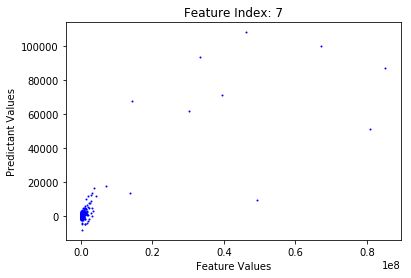

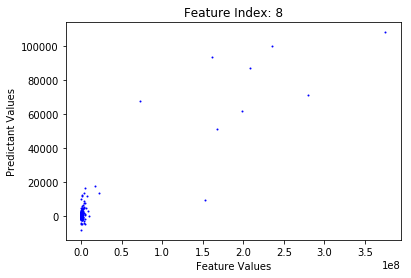

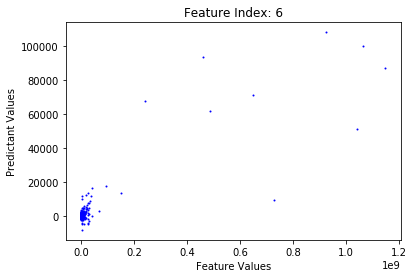


Hashtag:  superbowl
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     455.3
Date:                Sun, 18 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:23:06   Log-Likelihood:                -5740.9
No. Observations:                 586   AIC:                         1.152e+04
Df Residuals:                     565   BIC:                         1.162e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1757.8583    520.27

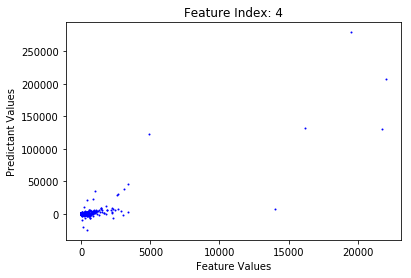

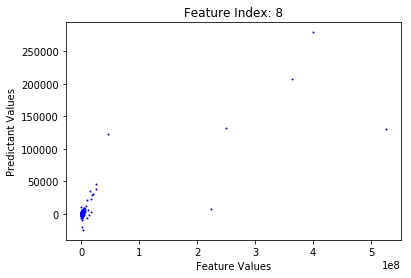

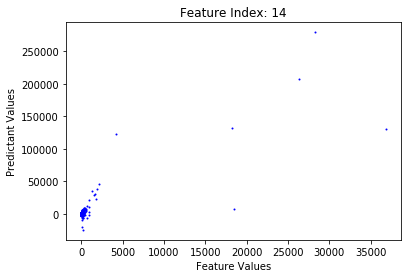

Feature Selection Using p-values


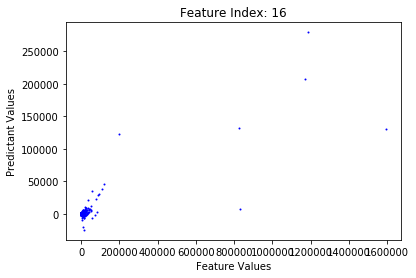

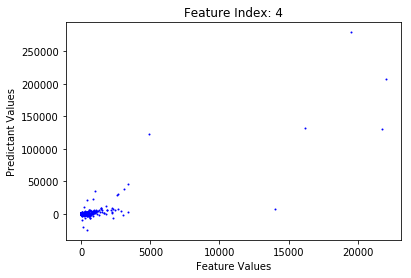

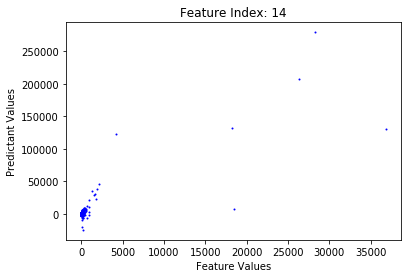

In [95]:
for hashtag in hashtagData:
    
    print("\nHashtag: ", hashtag)
    df = hashtagData[hashtag]
    features, _, _ = computeFeatures(df)
    labels = list()
    
    columns = df.columns
    
    for row in features[1:]:
        labels.append(row[0])
    del features[-1]
    
    X = np.array(features)
    y = np.array(labels)
    
    newX = sm.add_constant(X, prepend=True)
    model = sm.OLS(y, newX)
    
    results = model.fit()
    
    print(results.summary())
    print("P-Values:",results.pvalues)
    predictions = results.predict()
    rmse = sqrt(metrics.mean_squared_error(y, predictions))
    print("\nRMSE: ", rmse)
    
    print("Feature Selection Using f Regression")
    fRegression = SelectKBest(f_regression, k=3)
    xf = fRegression.fit_transform(X, y)
    print(fRegression.get_support())
    support = fRegression.get_support()
    
    print("Feature Selection Using SelectKBest")
    for i in range(len(support)):
        if support[i] == True:
            #plot scatter plot
            colValue = list()
            for row in features:
                colValue.append(row[i])
            plt.plot(colValue, predictions, 'bo', markersize=1)
            plt.xlabel('Feature Values')
            plt.ylabel('Predictant Values')
            title = "Feature Index: " + str(i)
            plt.title(title)
            plt.show()
            
    print("Feature Selection Using p-values")
    pvals = results.pvalues
    #removing the pvalue of the constant
    pvals = np.delete(pvals, 0)
    #argsort
    argSortedpVals = np.argsort(np.array(pvals))
    for i in range(3):
        index = argSortedpVals[i]
        colValue = list()
        for row in features:
            colValue.append(row[index])
        plt.plot(colValue, predictions, 'bo', markersize=1)
        plt.xlabel('Feature Values')
        plt.ylabel('Predictant Values')
        title = "Feature Index: " + str(index)
        plt.title(title)
        plt.show()
        

### 1.4

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.metrics import mean_squared_error
import sys
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


def getModel(modelName, arg=None):
    model = None
    if modelName == 'LinearRegression':
        model = LinearRegression()
            
    if modelName == 'KNeighborsRegressor':
        model = KNeighborsRegressor(n_neighbors=arg[0])
  
    if modelName == 'RandomForestRegressor':
        model = RandomForestRegressor(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
        
    return model


def regression(modelName, args, X, y, verbose=True):
      
    kf = KFold(n_splits=10, shuffle=True)
    
    trainMSE = list()
    testMSE = list()
    
    for train_index, test_index in kf.split(X):
            
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getModel(modelName, arg=args)

        model.fit(X_train, y_train)
        
        predictionTest = model.predict(X_test)
        predictionTrain = model.predict(X_train)
        
        train_mse = mean_squared_error(y_train, predictionTrain)
        test_mse = mean_squared_error(y_test, predictionTest)
        trainMSE.append(train_mse)
        testMSE.append(test_mse)

    trainRMSE = sqrt(sum(trainMSE) / len(trainMSE))
    testRMSE = sqrt(sum(testMSE) / len(testMSE))
    
    if verbose:
        print("Training MSE for each fold : ", trainMSE, "\n\n")
        print("Testing MSE for each fold : ", testMSE, "\n\n")
        print("Training RMSE:",trainRMSE)
        print("Testing RMSE:",testRMSE, "\n\n\n")
    
    return trainRMSE, testRMSE

In [90]:
model1Map = dict()
model2Map = dict()
model3Map = dict()

for hashtag in hashtagData:
    
    print("\nHashtag: ", hashtag)
    df = hashtagData[hashtag]
    
    labels = list()
    features, index1, index2 = computeFeatures(df)
    
    for row in features[1:]:
        labels.append(row[0])
    del features[-1]
    
    X = np.array(features)
    y = np.array(labels)
    
    X1 = X[:index1]
    y1 = y[:index1]

    X2 = X[index1:index2]
    y2 = y[index1:index2]

    X3 = X[index2:]
    y3 = y[index2:]
    
    print("\n\nModel 1")
    args = []
    _, m1_x1_test_rmse = regression('LinearRegression', args, X1, y1)
    _, m1_x2_test_rmse = regression('LinearRegression', args, X2, y2)
    _, m1_x3_test_rmse = regression('LinearRegression', args, X3, y3)
    
    print("\n\nModel 2")
    args = [20, 4, 5]
    _, m2_x1_test_rmse = regression('RandomForestRegressor', args, X1, y1)
    _, m2_x2_test_rmse = regression('RandomForestRegressor', args, X2, y2)
    _, m2_x3_test_rmse = regression('RandomForestRegressor', args, X3, y3)
    
    print("\n\nModel 3")
    args = [5]
    _, m3_x1_test_rmse = regression('KNeighborsRegressor', args, X1, y1)
    _, m3_x2_test_rmse = regression('KNeighborsRegressor', args, X2, y2)
    _, m3_x3_test_rmse = regression('KNeighborsRegressor', args, X3, y3)
    
    l = [m1_x1_test_rmse, m2_x1_test_rmse, m3_x1_test_rmse]
    min_test_index = np.argmin(l)
    if (min_test_index == 0):
        model1Map['LinearRegression'] = model1Map.get('LinearRegression', 0) + 1
    elif (min_test_index == 1):
        model1Map['RandomForestRegressor'] = model1Map.get('RandomForestRegressor', 0) + 1
    else:
        model1Map['KNeighborsRegressor'] = model1Map.get('KNeighborsRegressor', 0) + 1
        
    l = [m1_x2_test_rmse, m2_x2_test_rmse, m3_x2_test_rmse]
    min_test_index = np.argmin(l)
    if (min_test_index == 0):
        model2Map['LinearRegression'] = model2Map.get('LinearRegression', 0) + 1
    elif (min_test_index == 1):
        model2Map['RandomForestRegressor'] = model2Map.get('RandomForestRegressor', 0) + 1
    else:
        model2Map['KNeighborsRegressor'] = model2Map.get('KNeighborsRegressor', 0) + 1
    
    l = [m1_x3_test_rmse, m2_x3_test_rmse, m3_x3_test_rmse]
    min_test_index = np.argmin(l)
    if (min_test_index == 0):
        model3Map['LinearRegression'] = model3Map.get('LinearRegression', 0) + 1
    elif (min_test_index == 1):
        model3Map['RandomForestRegressor'] = model3Map.get('RandomForestRegressor', 0) + 1
    else:
        model3Map['KNeighborsRegressor'] = model3Map.get('KNeighborsRegressor', 0) + 1
        
        
print(model1Map)
print(model2Map)
print(model3Map)
    


Hashtag:  gohawks


Model 1
Training MSE for each fold :  [256407.9986428986, 185183.55873879787, 258464.03396549422, 255034.0679682557, 186579.19128450507, 25905.4983327, 256645.04522873712, 120758.28666642406, 265347.97744193324, 246747.73834013724] 


Testing MSE for each fold :  [274856.11618143733, 2232267.539784671, 132017.48001802072, 285503.1901690034, 6362679.366296023, 5494484.228410262, 147417.1628957904, 156696996.68164146, 65387.09091252351, 248768.80223786324] 


Training RMSE: 453.5497102424257
Testing RMSE: 4146.56939720713 



Training MSE for each fold :  [3.395067681909846e-17, 3.9993900961940314e-17, 8.09693437633175e-17, 1.6706360280974635e-17, 2.2630498994699014e-17, 1.112935827362526e-16, 9.301476585329258e-18, 2.873804820245094e-17, 6.999196077425777e-17, 9.04168868903413e-18] 


Testing MSE for each fold :  [43987184.336789355, 1831604.131260585, 752047.0487956333, 32920.418038097945, 5023671.482804279, 700096.3497112053, 70117260.9386872, 36470736.99481385, 8



Model 1
Training MSE for each fold :  [71524.85615808345, 67327.09018883262, 67940.26428017525, 24266.937183040456, 70136.67354225073, 70200.95440938916, 70164.38719477913, 53944.61107350987, 70547.38972077527, 68906.28743573026] 


Testing MSE for each fold :  [14949.552545450044, 62650.82710972121, 55519.251297620845, 500407.2321005722, 30976.810271198443, 42725.57534331318, 29304.495666263698, 1166315.8450422052, 27217.69947677402, 45453.92664523362] 


Training RMSE: 251.98401758575207
Testing RMSE: 444.46835832242914 



Training MSE for each fold :  [1.2631342429982802e-18, 4.56757448257678e-18, 1.6286989698992136e-15, 1.764407017694395e-17, 1.4305277299106077e-15, 3.3171913719736476e-16, 8.0397299265288e-18, 2.953790171157622e-16, 7.84973580424823e-16, 4.869654076319727e-18] 


Testing MSE for each fold :  [352075014.0691035, 26859395.65403397, 2208756.663869388, 703207363.2781386, 9818.999512661652, 7294557.919276089, 7079110.4929899275, 764327.7183166926, 1960.7893704896883,



Model 1
Training MSE for each fold :  [5284.02134612404, 5242.841860093605, 4893.671375072376, 4747.074622656458, 3901.0277755254356, 5665.22337799169, 5394.383772759318, 5632.254544498413, 5353.512418223626, 5292.112600035916] 


Testing MSE for each fold :  [7061.887655984544, 6315.125531433731, 9991.403393527597, 19510.50679345551, 22683.1410257044, 2030.0160543523396, 7054.849347628276, 3702.0868466897805, 5957.6478713364095, 6496.936533926398] 


Training RMSE: 71.69806391596698
Testing RMSE: 95.29092352057408 



Training MSE for each fold :  [3.614340746724114e-15, 1.0561229201697412e-14, 1.2636971168456513e-14, 9.467038687717869e-14, 1.980740407585104e-13, 9.936636235097172e-15, 2.7825344973527736e-14, 2.0352305851026645e-14, 3.088024381263629e-14, 4.4447431454660845e-14] 


Testing MSE for each fold :  [6852462389.826346, 175369367686.61655, 171038843789.31738, 2768032789.569099, 2699416452.161095, 47323388684.21113, 777946916.6908478, 298351263.32382286, 409207144.4365968, 

In [91]:
import operator

print("Best Model for window 1: ", max(model1Map.items(), key=operator.itemgetter(1))[0])
print("Best Model for window 2: ", max(model2Map.items(), key=operator.itemgetter(1))[0])
print("Best Model for window 3: ", max(model3Map.items(), key=operator.itemgetter(1))[0])

Best Model for window 1:  RandomForestRegressor
Best Model for window 2:  RandomForestRegressor
Best Model for window 3:  RandomForestRegressor


In [92]:
combined_df = pd.concat(hashtagData)

for hashtag in hashtagData:
    df = hashtagData[hashtag]
    print(hashtag, " : " , df.shape)
    
print("Combined dataframe: ", combined_df.shape)

features, index1, index2 = computeFeatures(combined_df)
labels = list()

for row in features[1:]:
    labels.append(row[0])
del features[-1]

X = np.array(features)
y = np.array(labels)

X1 = X[:index1]
y1 = y[:index1]

X2 = X[index1:index2]
y2 = y[index1:index2]

X3 = X[index2:]
y3 = y[index2:]

print("\n\nResults of RandomForestRegressor Model on three windows:")

args = [20, 4, 5]
_, m2_x1_test_rmse = regression('RandomForestRegressor', args, X1, y1)
_, m2_x2_test_rmse = regression('RandomForestRegressor', args, X2, y2)
_, m2_x3_test_rmse = regression('RandomForestRegressor', args, X3, y3)


gohawks  :  (188136, 18)
gopatriots  :  (26232, 18)
nfl  :  (259024, 18)
patriots  :  (489713, 18)
sb49  :  (826951, 18)
superbowl  :  (1348767, 18)
Combined dataframe:  (3138823, 18)


Results of RandomForestRegressor Model on three windows:
Training MSE for each fold :  [519994.2266682597, 1386918.8624819142, 1218712.4242815978, 1296092.6728096353, 1245967.3369428676, 1465004.9942440833, 1379277.785661966, 939947.4598352225, 1045402.2768380494, 1065505.3469771196] 


Testing MSE for each fold :  [35752401.41714834, 286112.6985051422, 1015067.4391528219, 1925595.6368634074, 785630.2892047506, 8618232.884620128, 446513.7229963312, 2969523.41169277, 3250684.363877822, 11184038.289241208] 


Training RMSE: 1075.3056954531914
Testing RMSE: 2573.592822365316 



Training MSE for each fold :  [2009658132.7691255, 1531189040.616639, 1735189795.487374, 939175369.3345451, 993013181.2152272, 1306410717.1015909, 760056588.7577274, 1773812823.4770455, 1593643551.880852, 1930536486.9540403] 


Tes

### 1.5

In [196]:
combined_df = pd.concat(hashtagData)

for hashtag in hashtagData:
    df = hashtagData[hashtag]
    print(hashtag, " : " , df.shape)
    
print("\n\nCombined dataframe: ", combined_df.shape)

features = []
features, index1, index2 = computeFeatures(combined_df, groupByFirstPostDate=True)
labels = list()

for row in features[5:]:
    labels.append(row[0])

features_5h = []

for row_index in range(len(features)-5):
    window = features[row_index:row_index+5]
    
    windowFeatures = []
    for windowRow in window:
        for windowRowFeature in windowRow:
            windowFeatures.append(windowRowFeature)
            
    features_5h.append(windowFeatures)

print("Number of concatenated features:", len(features_5h[0]))

X = np.array(features_5h)
y = np.array(labels)

print(X.shape)
print(y.shape)

X1 = X[:index1]
y1 = y[:index1]

X2 = X[index1:index2]
y2 = y[index1:index2]

X3 = X[index2:]
y3 = y[index2:]


arg = [20, 4, 5]

# combined_model = RandomForestRegressor(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
# combined_model.fit(X, y)

model1 = RandomForestRegressor(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
model1.fit(X1, y1)

model2 = RandomForestRegressor(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
model2.fit(X2, y2)

model3 = RandomForestRegressor(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
model3.fit(X3, y3)



gohawks  :  (188136, 18)
gopatriots  :  (26232, 18)
nfl  :  (259024, 18)
patriots  :  (489713, 18)
sb49  :  (826951, 18)
superbowl  :  (1348767, 18)


Combined dataframe:  (3138823, 18)
Number of concatenated features: 100
(976, 100)
(976,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [197]:
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt


pst_tz = pytz.timezone('US/Pacific')
oneHr = datetime.timedelta(minutes=60)

test_dir = 'test_data'

for root, dirs, files in os.walk(test_dir):
    path = root.split(os.sep)
    dateObj = None
    for f in files:
        print("\n\n", f)
        
        #avg no. of tweets per hr
        #avg no. of followers of users posting the tweets
        fullPath = "/".join(path) + "/" + f
        
        numTweetsPerHr = OrderedDict()
        numFollowers = dict()
        numRetweets = dict()
        
        fh = open(fullPath, 'r', encoding='utf8')
            
        df = fh_to_df(fh)
        
        print(df.shape)
                                
        test_features, _, _ = computeFeatures(df, groupByFirstPostDate=True)
        test_labels = list()

        for row in test_features[5:]:
            test_labels.append(row[0])

        test_features_5h = []

        for row_index in range(len(test_features)-4):
            testwindow = test_features[row_index:row_index+5]

            testwindowFeatures = []
            for testwindowRow in testwindow:
                for testwindowRowFeature in testwindowRow:
                    testwindowFeatures.append(testwindowRowFeature)

            test_features_5h.append(testwindowFeatures)

        if len(test_features_5h) > 0:
            print("Number of concatenated features:", len(test_features_5h[0]))

        X_test = np.array(test_features_5h[-1])
        X_test = X_test.reshape(-1, 100)
        
        y_test = np.array(test_labels)
        
        modelNum = f[-5:-4]
        model = None

        if modelNum == str(1):
            print(f, " lies in window 1")
            model = model1
        elif modelNum == str(2):
            print(f, " lies in window 2")
            model = model2
        else:
            print(f, " lies in window 3")
            model = model3
                
        if (X_test.shape[0] > 0):
            predictionTest = model.predict(X_test)
            print(f, " has prediction: ", predictionTest)
            
#             combinedpredictionTest = combined_model.predict(X_test)
#             print(f, " has prediction from combined: ", combinedpredictionTest)
        else:
            print("Could not construct a 5 hour window in ", f)



 sample10_period3.txt
(365, 18)
Number of concatenated features: 100
sample10_period3.txt  lies in window 3
sample10_period3.txt  has prediction:  [103.88382112]


 sample1_period1.txt
(730, 18)
Number of concatenated features: 100
sample1_period1.txt  lies in window 1
sample1_period1.txt  has prediction:  [128.65803446]


 sample2_period2.txt
(212273, 18)
Number of concatenated features: 100
sample2_period2.txt  lies in window 2
sample2_period2.txt  has prediction:  [147071.3]


 sample3_period3.txt
(3628, 18)
Number of concatenated features: 100
sample3_period3.txt  lies in window 3
sample3_period3.txt  has prediction:  [706.90925796]


 sample4_period1.txt
(1646, 18)
Number of concatenated features: 100
sample4_period1.txt  lies in window 1
sample4_period1.txt  has prediction:  [270.53596959]


 sample5_period1.txt
(2059, 18)
Number of concatenated features: 100
sample5_period1.txt  lies in window 1
sample5_period1.txt  has prediction:  [179.66642824]


 sample6_period2.txt
(20555

## Part 3

### Task1: Important Events analysis 

In [120]:
combined_df_sorted = combined_df.sort_values("date")

res = combined_df_sorted.query("(date >= '2015-02-01 15:30:00-08:00') & (date <= '2015-02-01 19:30:00-08:00')")

print(res.shape)
x = res.groupby(pd.Grouper(key='date', freq='min')) 

gb = x.groups

fifteen = datetime.timedelta(minutes=15)

startTime = None

count = 0

tweetList = []
windowTweets = []
minuteTweets = []
minuteWindowTweets = []

for key in gb.keys():
    var = x.get_group(key)

    if startTime is None:
        startTime = var['date'].iloc[0]
        
    current = var['date'].iloc[0]
        
    difference = current - startTime
    
    if difference.total_seconds() > 900:
        startTime = var['date'].iloc[0]
        tweetList.append(windowTweets)
        windowTweets = []

    for tweet in var['tweetText'].tolist():
        windowTweets.append(tweet)
        minuteWindowTweets.append(tweet)
        
    minuteTweets.append(minuteWindowTweets)
    minuteWindowTweets = []


(1304312, 18)


In [121]:
patriotMinuteTweets = []
hawkMinuteTweets = []

for tweetInterval in minuteTweets:
    patriots = []
    hawks = []
    
    for tweet in tweetInterval:
    
        if 'patriot' in tweet.lower():
            patriots.append(tweet)

        if 'hawk' in tweet.lower():
            hawks.append(tweet)

    patriotMinuteTweets.append(patriots)
    hawkMinuteTweets.append(hawks)
    
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

patriotPosCounts = []
patriotNegCounts = []
patriotNeuCounts = []

for tweetInterval in patriotMinuteTweets:
    posCount = 0
    negCount = 0
    neuCount = 0

    for tweet in tweetInterval:
        vaderanalysis = analyzer.polarity_scores(tweet)

        compound_score = vaderanalysis['compound']
        
        if compound_score > 0.4:
            posCount += 1
        elif compound_score > -0.4:
            neuCount += 1
        else:
            negCount += 1

#     print(posCount, negCount, neuCount)
    patriotPosCounts.append(posCount)
    patriotNegCounts.append(negCount)
    patriotNeuCounts.append(neuCount)
    

hawkPosCounts = []
hawkNegCounts = []
hawkNeuCounts = []

for tweetInterval in hawkMinuteTweets:
    posCount = 0
    negCount = 0
    neuCount = 0

    for tweet in tweetInterval:
        vaderanalysis = analyzer.polarity_scores(tweet)

        compound_score = vaderanalysis['compound']
        
        if compound_score > 0.4:
            posCount += 1
        elif compound_score > -0.4:
            neuCount += 1
        else:
            negCount += 1

#     print(posCount, negCount, neuCount)    
    hawkPosCounts.append(posCount)
    hawkNegCounts.append(negCount)
    hawkNeuCounts.append(neuCount)

#### The function to find peaks in a signal has been imported from a public source as mentioned below

In [124]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)


In [125]:
npPatriotPosCounts = np.array(patriotPosCounts)
npPatriotNegCounts = np.array(patriotNegCounts)

maxTabPatriot, minTabPatriot = peakdet(npPatriotPosCounts, 0.5)
# print(maxTab)
meanPatriotPosCount = np.mean(npPatriotPosCounts)
stdPatriotPosCount = np.std(npPatriotPosCounts)

npHawkPosCounts = np.array(hawkPosCounts)
npHawkNegCounts = np.array(hawkNegCounts)
meanHawkPosCount = np.mean(npHawkPosCounts)
stdHawkPosCount = np.std(npHawkPosCounts)

maxTabHawk, minTabHawk = peakdet(npHawkPosCounts, 0.5)

impEventsPatriot = []
for minMark in maxTabPatriot:
    if npPatriotPosCounts[minMark[0]] > meanPatriotPosCount+0.9*stdPatriotPosCount:
        impEventsPatriot.append(minMark[0])

impEventsHawk = []
for minMark in maxTabHawk:
    if npHawkPosCounts[minMark[0]] > meanHawkPosCount+1.0*stdHawkPosCount:
        impEventsHawk.append(minMark[0])

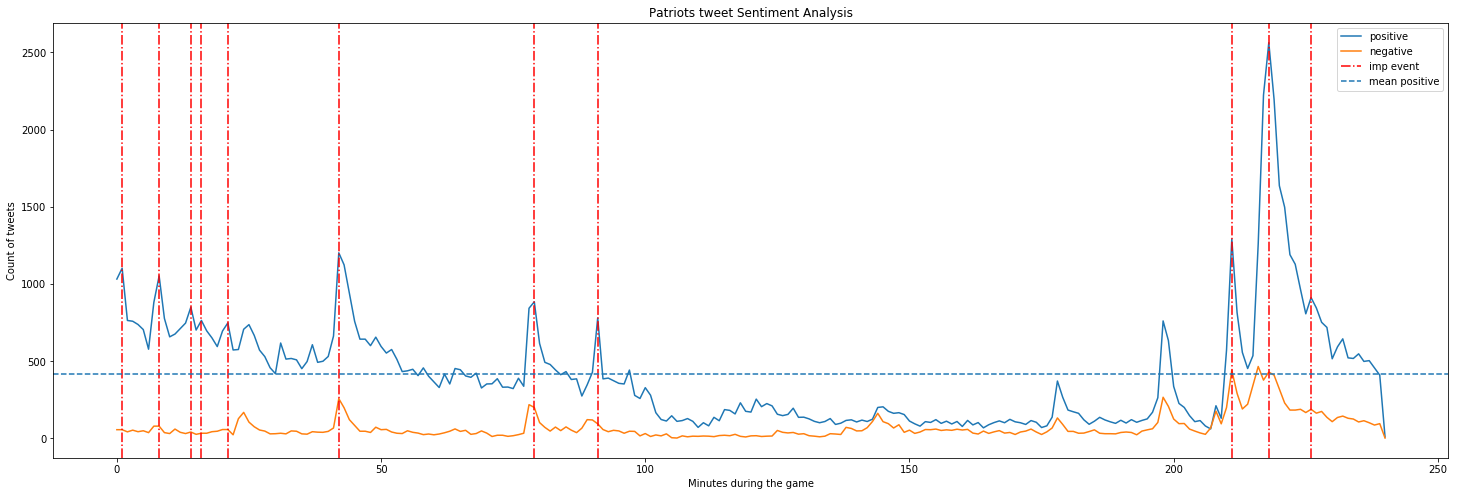

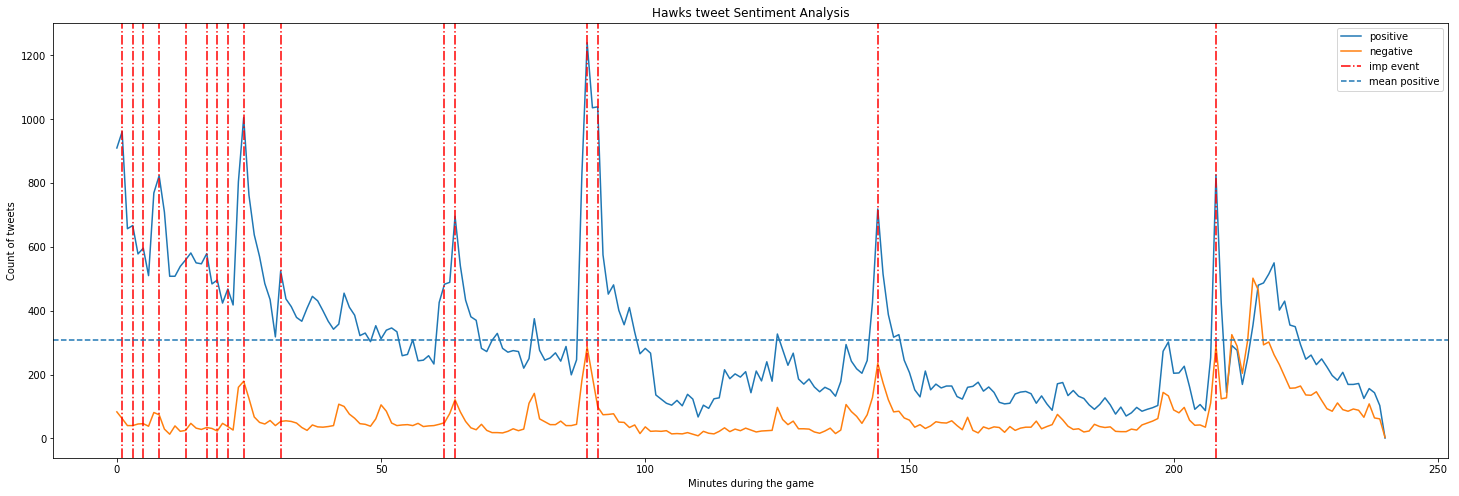

In [148]:
plt.figure(figsize=[25,8])
plt.plot(patriotPosCounts, label='positive')
plt.plot(patriotNegCounts, label='negative')
for minMark in impEventsPatriot:
    plt.axvline(x=minMark, color = 'r', label='imp event', linestyle='-.')
plt.axhline(y=meanPatriotPosCount, linestyle='--', label='mean positive')
# plt.axhline(y=meanPatriotPosCount+stdPatriotPosCount, color='b', linestyle='--')

plt.legend()
plt.title("Patriots tweet Sentiment Analysis")
plt.xlabel('Minutes during the game')
plt.ylabel('Count of tweets')
plt.show()

plt.figure(figsize=[25,8])
plt.plot(hawkPosCounts, label='positive')
plt.plot(hawkNegCounts, label='negative')
for minMark in impEventsHawk:
    plt.axvline(x=minMark, color = 'r',label='imp event', linestyle='-.')
plt.axhline(y=meanHawkPosCount, linestyle='--', label='mean positive')
# plt.axhline(y=meanHawkPosCount+stdHawkPosCount, color='b', linestyle='--')


plt.legend()
plt.title("Hawks tweet Sentiment Analysis")
plt.xlabel('Minutes during the game')
plt.ylabel('Count of tweets')
plt.show()

In [149]:
npPatriotPosCounts = np.array(patriotPosCounts)
npPatriotNegCounts = np.array(patriotNegCounts)

npPatriotRatio = np.divide(npPatriotPosCounts, npPatriotPosCounts+npPatriotNegCounts)
meanPatriotRatio = np.mean(npPatriotRatio)
stdPatriotRatio = np.std(npPatriotRatio)

npPatriotDiff = np.subtract(npPatriotPosCounts, npPatriotNegCounts)
meanPatriotDiff = np.mean(npPatriotDiff)
stdPatriotDiff = np.std(npPatriotDiff)

maxTabPatriot, minTabPatriot = peakdet(npPatriotDiff, 0.5)
# print(len(maxTabPatriot))
# print(maxTabPatriot)

impEventsPatriot = []
for minMark in maxTabPatriot:
    if npPatriotDiff[int(minMark[0])] > meanPatriotDiff+1*stdPatriotDiff:
        impEventsPatriot.append(int(minMark[0]))

impEventsPatriot2 = []
for minMark in minTabPatriot:
    if npPatriotDiff[int(minMark[0])] < meanPatriotDiff-1*stdPatriotDiff:
        impEventsPatriot2.append(int(minMark[0]))
        
npHawkPosCounts = np.array(hawkPosCounts)
npHawkNegCounts = np.array(hawkNegCounts)

npHawkRatio = np.divide(npHawkPosCounts, npHawkPosCounts+npHawkNegCounts)
meanHawkRatio = np.mean(npHawkRatio)

npHawkDiff = np.subtract(npHawkPosCounts, npHawkNegCounts)
meanHawkDiff = np.mean(npHawkDiff)
stdHawkDiff = np.std(npHawkDiff)

maxTabHawk, minTabHawk = peakdet(npHawkDiff, 0.5)
# print(len(maxTabHawk))
# print(maxTabPatriot)

impEventsHawk = []
for minMark in maxTabHawk:
    if npHawkDiff[int(minMark[0])] > meanHawkDiff+1*stdHawkDiff:
        impEventsHawk.append(int(minMark[0]))

impEventsHawk2 = []
for minMark in minTabHawk:
    if npHawkDiff[int(minMark[0])] < meanHawkDiff-1*stdHawkDiff:
        impEventsHawk2.append(int(minMark[0]))
        
print("Patriots imp events(good):", impEventsPatriot)
print("Patriots imp events(bad):", impEventsPatriot2)
print("Hawks imp events(good):", impEventsHawk)
print("Hawks imp events(bad):", impEventsHawk2)

Patriots imp events(good): [1, 8, 14, 16, 21, 42, 79, 91, 211, 218, 226]
Patriots imp events(bad): [143, 160, 164, 207]
Hawks imp events(good): [1, 3, 5, 8, 13, 17, 19, 21, 24, 31, 62, 64, 89, 91, 144, 208]
Hawks imp events(bad): [177, 185, 197, 211, 215]


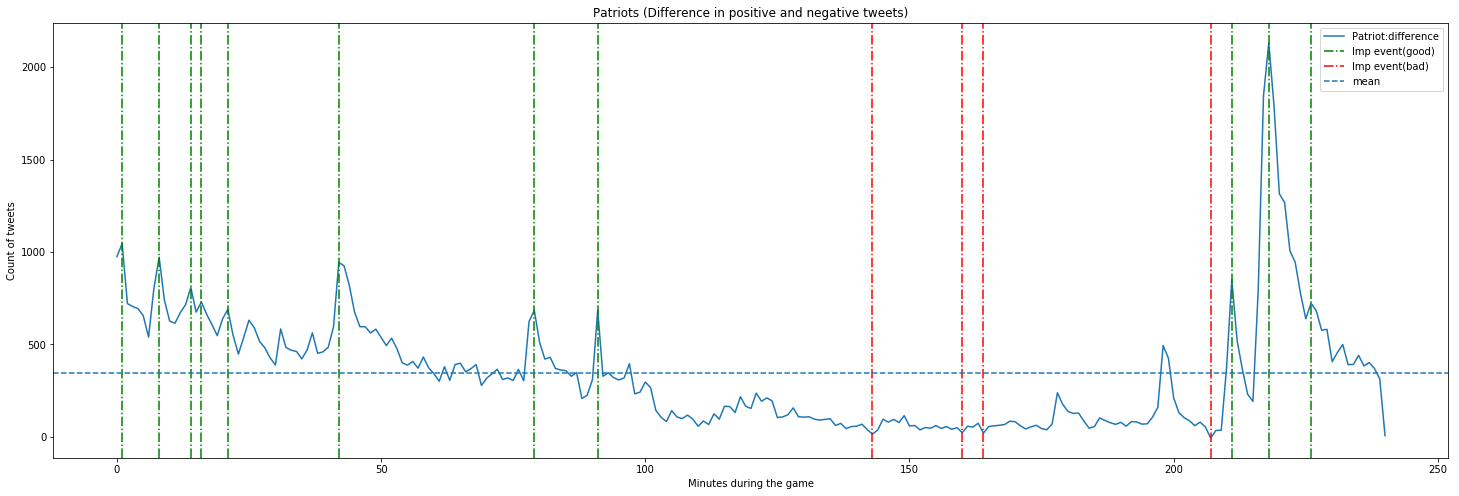

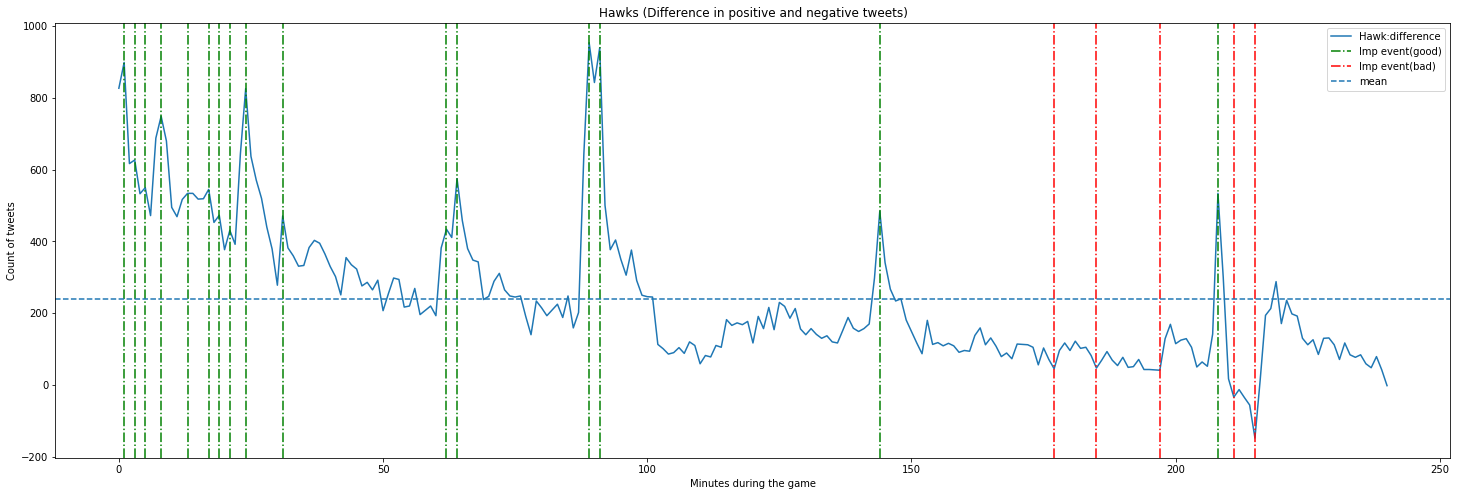

In [150]:
plt.figure(figsize=[25,8])
plt.plot(npPatriotDiff, label='Patriot:difference')
for minMark in impEventsPatriot:
    plt.axvline(x=minMark, color = 'g', label='Imp event(good)', linestyle='-.')
for minMark in impEventsPatriot2:
    plt.axvline(x=minMark, color = 'r', label='Imp event(bad)', linestyle='-.')
plt.axhline(y=meanPatriotDiff,label='mean',linestyle='--')
# plt.axhline(y=meanPatriotDiff+stdPatriotDiff, color='b', linestyle='--')
# plt.axhline(y=meanPatriotDiff-stdPatriotDiff, color='b', linestyle='--')

plt.legend()
plt.title("Patriots (Difference in positive and negative tweets)")
plt.xlabel('Minutes during the game')
plt.ylabel('Count of tweets')
plt.show()

plt.figure(figsize=[25,8])
plt.plot(npHawkDiff, label='Hawk:difference')
for minMark in impEventsHawk:
    plt.axvline(x=minMark, color = 'g', label='Imp event(good)', linestyle='-.')
for minMark in impEventsHawk2:
    plt.axvline(x=minMark, color = 'r', label='Imp event(bad)', linestyle='-.')

plt.axhline(y=meanHawkDiff,label='mean',linestyle='--')
# plt.axhline(y=meanHawkDiff-stdHawkDiff, color='b', linestyle='--')
# plt.axhline(y=meanHawkDiff+stdHawkDiff, color='b', linestyle='--')

plt.legend()
plt.title("Hawks (Difference in positive and negative tweets)")

plt.xlabel('Minutes during the game')
plt.ylabel('Count of tweets')
plt.show()

### Task 2: People that were most tweeted 

In [164]:
from stanfordcorenlp import StanfordCoreNLP
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

combined_df = pd.concat(hashtagData)

combined_df_sorted = combined_df.sort_values("date")

res = combined_df_sorted.query("(date >= '2015-02-01 15:30:00-08:00') & (date <= '2015-02-01 19:30:00-08:00')")

In [165]:
res.shape

(1304312, 18)

In [166]:
def preprocess(sample_tweet):
    return re.sub('[^0-9a-zA-Z]+', ' ', sample_tweet) 

#### The below block takes 5+ hours to run. Please load the pickle file provided in the next block

In [ ]:
nlp = StanfordCoreNLP(r'http://localhost', port=8000)
# nlp = StanfordCoreNLP('http://corenlp.run', port=80)

from collections import defaultdict
person_count = dict()
analyzer = SentimentIntensityAnalyzer()

for tweet in res['tweetText']:
    try:
        #     print(tweet)
        posCount = 0
        neuCount = 0
        negCount = 0
        vaderanalysis = analyzer.polarity_scores(tweet)
        compund_score = vaderanalysis['compound']

        if compund_score > 0.3:
            posCount = 1
        elif compund_score > -0.3:
            neuCount = 1
        else:
            negCount = 1

        tweet = preprocess(tweet)

        entities = nlp.ner(tweet)
        last_entity = ("","")
        last_key = ""
        for entity in entities:
            if(last_entity[1] == "PERSON" and entity[1] == "PERSON"):
                key = last_key + " " + entity[0]
                if key not in person_count:
                    person_count[key] = [0,0,0,0]

                person_count[key][0] += 1
                person_count[key][1] += posCount
                person_count[key][2] += neuCount
                person_count[key][3] += negCount


                del person_count[last_key]
                last_key = key

            elif(entity[1] == "PERSON"):
                key = entity[0]
                if key not in person_count:
                    person_count[key] = [0,0,0,0]

                person_count[key][0] += 1
                person_count[key][1] += posCount
                person_count[key][2] += neuCount
                person_count[key][3] += negCount
                last_key = entity[0]

            last_entity = entity
            
    except Exception as e:
        print("ERROR............................" + str(e))
nlp.close()

In [170]:
# person_count = OrderedDict(pickle.load(open("sorted_person_count_full",'rb')))

In [171]:
sorted_person_count = sorted(person_count.items(), key=lambda e: e[1][0], reverse=True)

In [172]:
sorted_person_count

[('Bruce Jenner', [326, 51, 228, 47]),
 ('Kim Kanye', [305, 46, 217, 42]),
 ('Michelle Tafoya', [281, 13, 261, 7]),
 ('CHRIS MATTHEWS', [207, 30, 161, 16]),
 ('Braylon O Neill', [193, 179, 13, 1]),
 ('Don', [178, 63, 77, 38]),
 ('Roger Goodell', [145, 65, 67, 13]),
 ('Snape Cinna', [144, 14, 127, 3]),
 ('Imma', [124, 58, 44, 22]),
 ('Tom Brady Brandon LaFell', [104, 8, 93, 3]),
 ('Beyonc', [104, 76, 20, 8]),
 ('Ernesto Cordero', [100, 7, 92, 1]),
 ('Will Ferrell', [100, 54, 40, 6]),
 ('Debbie Downer', [97, 36, 55, 6]),
 ('Wilson', [94, 32, 42, 20]),
 ('Anotaci', [92, 1, 87, 4]),
 ('Tharold Simon', [92, 18, 54, 20]),
 ('Gruber', [92, 14, 56, 22]),
 ('Antonio Freeman', [89, 80, 7, 2]),
 ('Richard Sherman', [85, 12, 50, 23]),
 ('Bobby Wagner', [83, 16, 62, 5]),
 ('LIAM NEESON', [80, 25, 47, 8]),
 ('Rob Ninkovich', [72, 3, 8, 61]),
 ('Chris Collinsworth', [72, 15, 37, 20]),
 ('LeGarrette Blount', [71, 20, 46, 5]),
 ('Despu', [70, 9, 52, 9]),
 ('Lombardi', [70, 18, 50, 2]),
 ('Pete Carroll'

In [ ]:
# import pickle
# pickle.dump(sorted_person_count, open("sorted_person_count_full",'wb'), protocol=2)

In [173]:
import pickle
import Levenshtein
from collections import OrderedDict

sorted_person_count = OrderedDict(pickle.load(open("sorted_person_count_full",'rb')))
sorted(sorted_person_count.items(), key=lambda e: e[1][0], reverse=True)
# for key in list(sorted_person_count):
#     print(key)
print(len(sorted_person_count))


40229


In [174]:
superbowl_pattern = re.compile('SuperBowlXLIX|Superbowl|HalftimeShow|GoHawks|GoPatriots', re.IGNORECASE)

In [ ]:
for key1 in list(sorted_person_count):
    for key2 in list(sorted_person_count):
        if key1 == key2:
            continue
#         print(key1)
#         print(key2)
        tkey1 = (re.sub(superbowl_pattern,'',key1)).lower()
        tkey2 = (re.sub(superbowl_pattern,'',key2)).lower()

        if Levenshtein.ratio(tkey1, tkey2) > 0.65:
            if key1 in sorted_person_count and key2 in sorted_person_count:
                if re.search(superbowl_pattern, key1):
                    key1, key2 = key2, key1
                sorted_person_count[key1][0] += sorted_person_count[key2][0]
                sorted_person_count[key1][1] += sorted_person_count[key2][1]
                sorted_person_count[key1][2] += sorted_person_count[key2][2]
                sorted_person_count[key1][3] += sorted_person_count[key2][3]

                del sorted_person_count[key2]
print(len(sorted_person_count))

In [ ]:
# final_sorted_person_count = sorted(sorted_person_count.items(), key=lambda e: e[1][0], reverse=True)

In [ ]:
# print(final_sorted_person_count)
# pickle.dump(final_sorted_person_count, open("final_sorted_person_count_full",'wb'), protocol=2)

In [175]:
final_sorted_person_count = OrderedDict(pickle.load(open("final_sorted_person_count_full",'rb')))
sorted(final_sorted_person_count.items(), key=lambda e: e[1][0], reverse=True)
print(len(final_sorted_person_count))

12160


In [181]:
final_sorted_person_count

OrderedDict([('Katy Perrys', [2309, 606, 1498, 205]),
             ('missy Elliott', [1551, 430, 933, 188]),
             ('TOM BRADY', [1480, 401, 921, 158]),
             ('CHRIS MATTHEWS', [892, 227, 588, 77]),
             ('Lenny kravitz', [825, 252, 482, 91]),
             ('Russell Wilson', [724, 193, 433, 98]),
             ('Chris Collinsworth', [507, 160, 247, 100]),
             ('LIAM NEESON', [463, 206, 201, 56]),
             ('Wilson', [445, 120, 270, 55]),
             ('Edelman', [407, 108, 273, 26]),
             ('Pete Carroll', [393, 127, 181, 85]),
             ('Bill Belichick', [382, 128, 204, 50]),
             ('Gronkowski', [381, 71, 211, 99]),
             ('Bruce Jenner', [361, 62, 246, 53]),
             ('Kim Kanye', [349, 57, 246, 46]),
             ('Michelle Tafoya', [348, 41, 293, 14]),
             ('Elle', [294, 64, 197, 33]),
             ('Tom Brady Brandon LaFell', [290, 55, 220, 15]),
             ('Don', [265, 91, 117, 57]),
             ('Roger

In [182]:
total_person_count = dict()
pos_person_count = dict()
neu_person_count = dict()
neg_person_count = dict()

for key in final_sorted_person_count:
    total_person_count[key] = final_sorted_person_count[key][0]
    pos_person_count[key] = final_sorted_person_count[key][1]
    neu_person_count[key] = final_sorted_person_count[key][2]
    neg_person_count[key] = final_sorted_person_count[key][3]

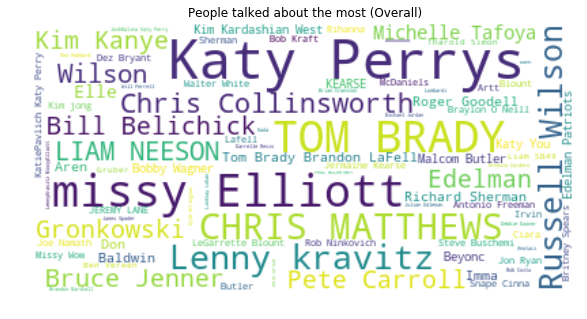

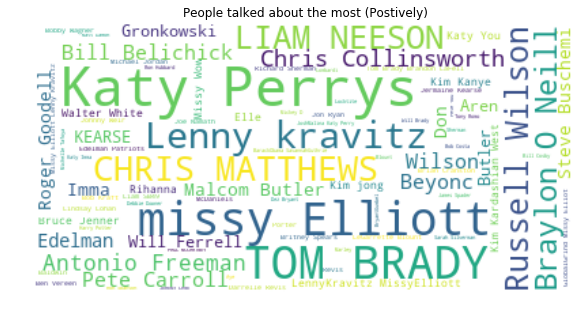

In [183]:
from os import path
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',colormap="viridis",max_font_size=40, max_words=100).generate_from_frequencies(dict(total_person_count))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("People talked about the most (Overall)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(background_color='white',max_font_size=40,colormap="viridis", max_words=100).generate_from_frequencies(dict(pos_person_count))
plt.figure(figsize=(10,5))
plt.title("People talked about the most (Postively)")

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Task 3: Organizations that were most tweeted about

In [184]:
from stanfordcorenlp import StanfordCoreNLP
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

combined_df = pd.concat(hashtagData)

combined_df_sorted = combined_df.sort_values("date")

res = combined_df_sorted.query("(date >= '2015-02-01 15:30:00-08:00') & (date <= '2015-02-01 19:30:00-08:00')")

In [185]:
res.shape

(1304312, 18)

In [186]:
def preprocess(sample_tweet):
    return re.sub('[^0-9a-zA-Z]+', ' ', sample_tweet) 

#### The below block takes 5+ hours to run. Please load the pickle file provided in the next block

In [68]:
nlp = StanfordCoreNLP(r'http://localhost', port=8000)
# nlp = StanfordCoreNLP('http://corenlp.run', port=80)

from collections import defaultdict
org_count = dict()
analyzer = SentimentIntensityAnalyzer()

for tweet in res['tweetText']:
    try:
        #     print(tweet)
        posCount = 0
        neuCount = 0
        negCount = 0
        vaderanalysis = analyzer.polarity_scores(tweet)
        compund_score = vaderanalysis['compound']

        if compund_score > 0.3:
            posCount = 1
        elif compund_score > -0.3:
            neuCount = 1
        else:
            negCount = 1

        tweet = preprocess(tweet)

        entities = nlp.ner(tweet)
        last_entity = ("","")
        last_key = ""
        for entity in entities:
            if(last_entity[1] == "ORGANIZATION" and entity[1] == "ORGANIZATION"):
                key = last_key + " " + entity[0]
                if key not in org_count:
                    org_count[key] = [0,0,0,0]

                org_count[key][0] += 1
                org_count[key][1] += posCount
                org_count[key][2] += neuCount
                org_count[key][3] += negCount


                del org_count[last_key]
                last_key = key

            elif(entity[1] == "ORGANIZATION"):
                key = entity[0]
                if key not in org_count:
                    org_count[key] = [0,0,0,0]

                org_count[key][0] += 1
                org_count[key][1] += posCount
                org_count[key][2] += neuCount
                org_count[key][3] += negCount
                last_key = entity[0]

            last_entity = entity
            
    except Exception as e:
        print("ERROR............................" + str(e))
nlp.close()

In [69]:
sortedCounts = sorted(org_count.items(), key=lambda e: e[1][0], reverse=True)

In [70]:
sortedCounts

[('McDonald', [222, 92, 94, 36]),
 ('Watch Seattle Seahawks', [172, 0, 172, 0]),
 ('Today Watch Seattle Seahawks', [153, 0, 153, 0]),
 ('Seattle Seahawks Live Online Stream TV', [142, 0, 142, 0]),
 ('EnEsteMomento Marcador Patriots', [124, 0, 124, 0]),
 ('Les Seahawks', [119, 8, 103, 8]),
 ('Walmart', [116, 66, 45, 5]),
 ('Seahawks NFL', [115, 37, 60, 18]),
 ('Giants', [113, 55, 43, 15]),
 ('Seattle NFL', [105, 21, 82, 2]),
 ('FIATUSA', [103, 3, 100, 0]),
 ('Honda', [90, 28, 52, 10]),
 ('ISIS Genocide ACA 2A Paris Patriots', [90, 18, 52, 20]),
 ('NFLTDA', [71, 4, 59, 8]),
 ('PSI', [71, 26, 42, 3]),
 ('Senate', [69, 19, 44, 6]),
 ('ISIS ACA 2A Paris Patriots', [68, 8, 36, 24]),
 ('Show de Medio Tiempo', [67, 2, 65, 0]),
 ('Disney Princess', [63, 8, 52, 3]),
 ('Edelman Patriots', [60, 6, 53, 1]),
 ('Buffalo Wild Wings', [59, 25, 30, 4]),
 ('Arnold', [57, 17, 31, 9]),
 ('NISSAN', [57, 15, 27, 15]),
 ('Patriots amp Seahawks', [56, 23, 28, 5]),
 ('NE Patriots', [56, 38, 18, 0]),
 ('NAZI', [

In [ ]:
# import pickle
# pickle.dump(sortedCounts, open("sorted_org_count_full",'wb'), protocol=2)

In [188]:
import pickle
import Levenshtein
from collections import OrderedDict

sorted_org_count = OrderedDict(pickle.load(open("sorted_org_count_full",'rb')))
sorted(sorted_org_count.items(), key=lambda e: e[1][0], reverse=True)
# for key in list(sorted_person_count):
#     print(key)
print(len(sorted_org_count))


24736


In [189]:
superbowl_pattern = re.compile('SuperBowlXLIX|Superbowl|HalftimeShow|GoHawks|GoPatriots', re.IGNORECASE)

In [104]:
for key1 in list(sorted_org_count):
    for key2 in list(sorted_org_count):
        if key1 == key2:
            continue
#         print(key1)
#         print(key2)
        tkey1 = (re.sub(superbowl_pattern,'',key1)).lower()
        tkey2 = (re.sub(superbowl_pattern,'',key2)).lower()

        if Levenshtein.ratio(tkey1, tkey2) > 0.65:
            if key1 in sorted_org_count and key2 in sorted_org_count:
                if re.search(superbowl_pattern, key1):
                    key1, key2 = key2, key1
                sorted_org_count[key1][0] += sorted_org_count[key2][0]
                sorted_org_count[key1][1] += sorted_org_count[key2][1]
                sorted_org_count[key1][2] += sorted_org_count[key2][2]
                sorted_org_count[key1][3] += sorted_org_count[key2][3]

                del sorted_org_count[key2]
print(len(sorted_org_count))

9116


In [105]:
final_sorted_org_count = sorted(sorted_org_count.items(), key=lambda e: e[1][0], reverse=True)

In [176]:
final_sorted_org_count

[('Les Seahawks', [2723, 603, 1804, 316]),
 ('Watch Seattle Seahawks', [1713, 330, 1270, 113]),
 ('Edelman Patriots', [1116, 272, 753, 91]),
 ('Seattle NFL', [986, 262, 600, 124]),
 ('Patriots amp Seahawks', [615, 173, 405, 37]),
 ('Seahawks amp Patriots', [490, 148, 292, 50]),
 ('McDonald', [369, 154, 158, 57]),
 ('Seahawks Lynch', [362, 87, 224, 51]),
 ('PSI', [238, 72, 137, 29]),
 ('NBC NFL', [226, 91, 104, 31]),
 ('BBCBreaking New England Patriots', [208, 79, 123, 6]),
 ('Les Pats', [207, 49, 139, 19]),
 ('Brady NFL', [206, 60, 129, 17]),
 ('Gronk Touchdown Patriots', [204, 35, 155, 14]),
 ('Seattle Seahawks Live Online Stream TV', [199, 21, 176, 2]),
 ('Marshon Lynch', [190, 56, 117, 17]),
 ('Giants', [187, 79, 83, 25]),
 ('UniversityOfPhoenixStadium AP', [178, 36, 132, 10]),
 ('NISSAN', [171, 60, 78, 33]),
 ('New England NFL', [168, 46, 112, 10]),
 ('Walmart', [165, 77, 79, 9]),
 ('ZonaRoja Patriots', [162, 45, 113, 4]),
 ('ISIS Genocide ACA 2A Paris Patriots', [159, 26, 89, 44])

In [177]:
# pickle.dump(final_sorted_org_count, open("final_sorted_org_count_full",'wb'), protocol=2)

In [190]:
final_sorted_org_count = OrderedDict(pickle.load(open("final_sorted_org_count_full",'rb')))
sorted(final_sorted_org_count.items(), key=lambda e: e[1][0], reverse=True)
print(len(final_sorted_org_count))


9116


In [191]:
final_sorted_org_count

OrderedDict([('Les Seahawks', [2723, 603, 1804, 316]),
             ('Watch Seattle Seahawks', [1713, 330, 1270, 113]),
             ('Edelman Patriots', [1116, 272, 753, 91]),
             ('Seattle NFL', [986, 262, 600, 124]),
             ('Patriots amp Seahawks', [615, 173, 405, 37]),
             ('Seahawks amp Patriots', [490, 148, 292, 50]),
             ('McDonald', [369, 154, 158, 57]),
             ('Seahawks Lynch', [362, 87, 224, 51]),
             ('PSI', [238, 72, 137, 29]),
             ('NBC NFL', [226, 91, 104, 31]),
             ('BBCBreaking New England Patriots', [208, 79, 123, 6]),
             ('Les Pats', [207, 49, 139, 19]),
             ('Brady NFL', [206, 60, 129, 17]),
             ('Gronk Touchdown Patriots', [204, 35, 155, 14]),
             ('Seattle Seahawks Live Online Stream TV', [199, 21, 176, 2]),
             ('Marshon Lynch', [190, 56, 117, 17]),
             ('Giants', [187, 79, 83, 25]),
             ('UniversityOfPhoenixStadium AP', [178, 36, 132

In [194]:
total_person_count = dict()
pos_person_count = dict()
neu_person_count = dict()
neg_person_count = dict()

for key in final_sorted_org_count:
    total_person_count[key] = final_sorted_org_count[key][0]
    pos_person_count[key] = final_sorted_org_count[key][1]
    neu_person_count[key] = final_sorted_org_count[key][2]
    neg_person_count[key] = final_sorted_org_count[key][3]
    
    

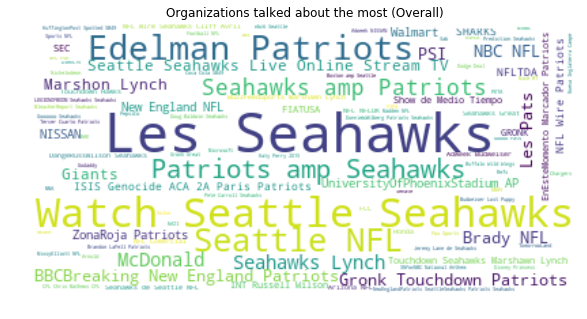

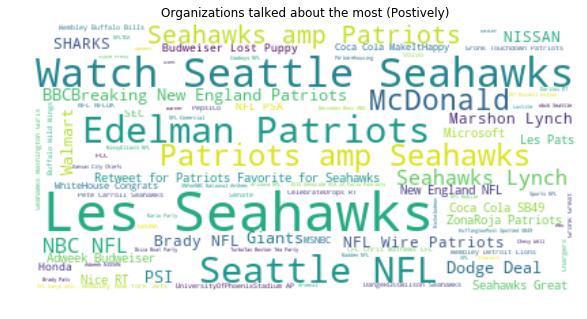

In [195]:
from os import path
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',colormap="viridis",max_font_size=40, max_words=100).generate_from_frequencies(dict(total_person_count))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Organizations talked about the most (Overall)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(background_color='white',max_font_size=40,colormap="viridis", max_words=100).generate_from_frequencies(dict(pos_person_count))
plt.figure(figsize=(10,5))
plt.title("Organizations talked about the most (Postively)")

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## END OF NOTEBOOK